# Question 6: Derivative of Gaussian

## Part (a): Mathematical Derivation
We are given the 2D Gaussian function:
$$G(x,y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2+y^2}{2\sigma^2}}$$

We need to find the partial derivative with respect to $x$:
$$\frac{\partial G}{\partial x} = \frac{1}{2\pi\sigma^2} \frac{\partial}{\partial x} \left( e^{-\frac{x^2+y^2}{2\sigma^2}} \right)$$

Using the chain rule, let $u = -\frac{x^2+y^2}{2\sigma^2}$. Then $\frac{\partial u}{\partial x} = -\frac{2x}{2\sigma^2} = -\frac{x}{\sigma^2}$.

$$\frac{\partial G}{\partial x} = \frac{1}{2\pi\sigma^2} e^{u} \cdot \frac{\partial u}{\partial x}$$
$$\frac{\partial G}{\partial x} = \left( \frac{1}{2\pi\sigma^2} e^{-\frac{x^2+y^2}{2\sigma^2}} \right) \cdot \left( -\frac{x}{\sigma^2} \right)$$

Substituting $G(x,y)$ back into the equation:
$$\frac{\partial G}{\partial x} = -\frac{x}{\sigma^2} G(x,y)$$

Similarly, for $y$:
$$\frac{\partial G}{\partial y} = -\frac{y}{\sigma^2} G(x,y)$$

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
def create_derivative_gaussian_kernel(k_size, sigma, direction='x'):
    """
    Creates a derivative of Gaussian kernel.
    Direction: 'x' or 'y'
    """
    center = k_size // 2
    x, y = np.meshgrid(np.arange(-center, center + 1), 
                       np.arange(-center, center + 1))
    
    # 1. Base Gaussian Term G(x,y)
    exponent = -(x**2 + y**2) / (2 * sigma**2)
    G = (1 / (2 * np.pi * sigma**2)) * np.exp(exponent)
    
    # 2. Derivative Term
    if direction == 'x':
        # dG/dx = -x/sigma^2 * G
        kernel = - (x / sigma**2) * G
    else:
        # dG/dy = -y/sigma^2 * G
        kernel = - (y / sigma**2) * G
        
    # Note: Derivative kernels sum to 0. 
    # To "normalize" for visualization or consistent magnitude, 
    # we often just return the raw values or scale them.
    # Here we return raw values as per the mathematical formula.
    return kernel

In [3]:
sigma = 2
k_size = 5

kernel_x = create_derivative_gaussian_kernel(k_size, sigma, 'x')
kernel_y = create_derivative_gaussian_kernel(k_size, sigma, 'y')

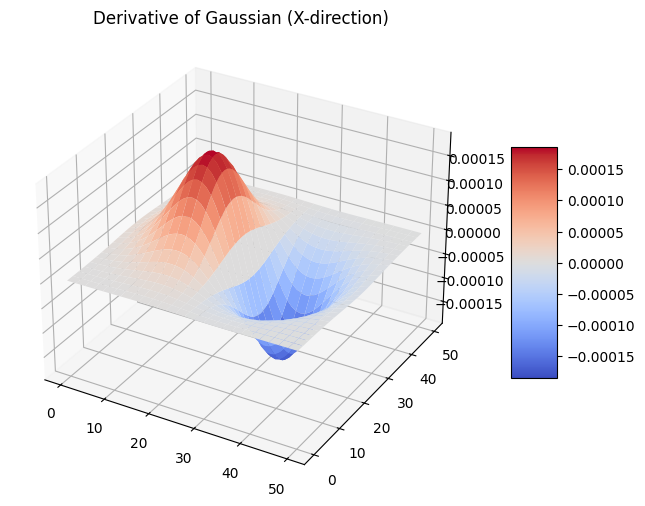

In [4]:
viz_size = 51
viz_sigma = 8
viz_kernel_x = create_derivative_gaussian_kernel(viz_size, viz_sigma, 'x')

X, Y = np.meshgrid(np.arange(viz_size), np.arange(viz_size))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
# This should look like a wave (up and down)
surf = ax.plot_surface(X, Y, viz_kernel_x, cmap='coolwarm', linewidth=0)
ax.set_title(f'Derivative of Gaussian (X-direction)')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Saved Q6 images to ../images/outputs/


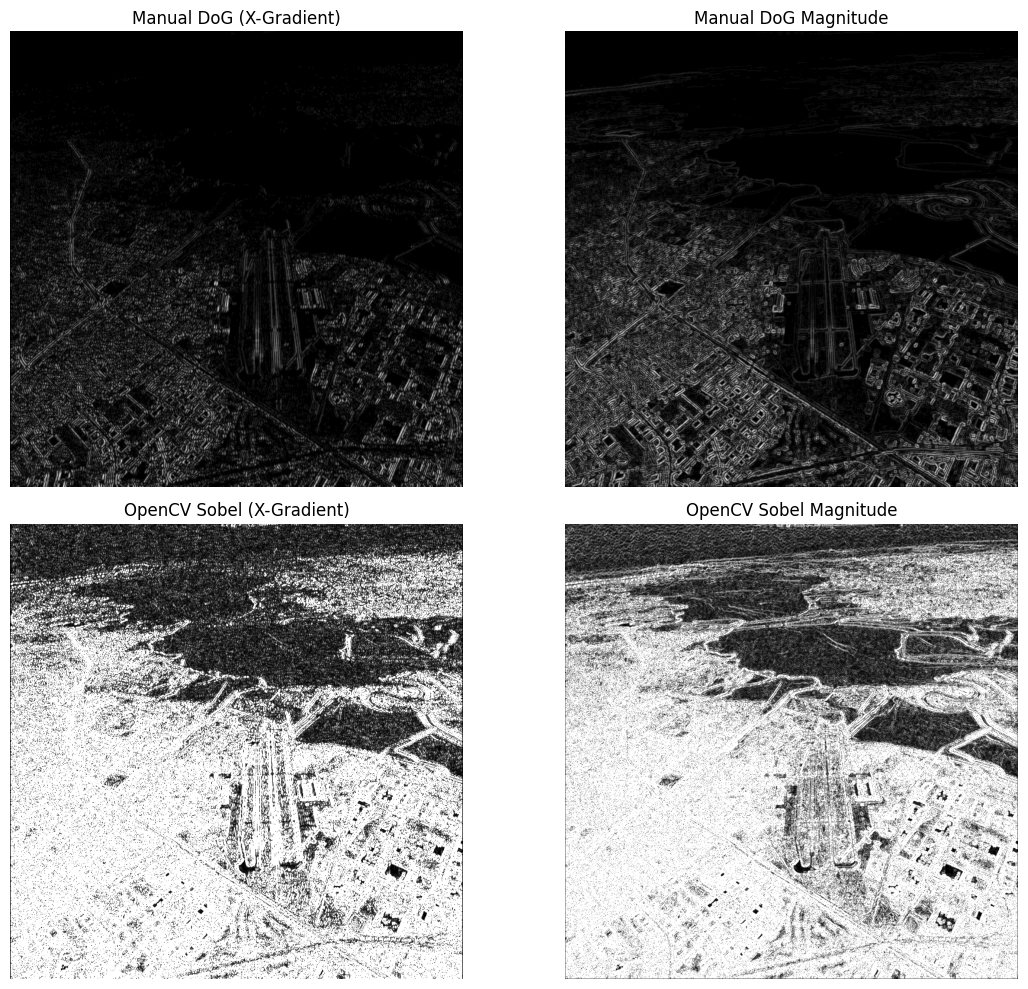

In [8]:
import os

img_path = '../images/runway.png' 
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

if img is None:
    print("Error: Load image first.")
else:
    # Convolve with our manual kernels (Results are Float64)
    grad_x_manual = cv2.filter2D(img, cv2.CV_64F, kernel_x)
    grad_y_manual = cv2.filter2D(img, cv2.CV_64F, kernel_y)
    
    # NORMALIZE to 0-255 range for Saving/Visualization
    abs_grad_x = cv2.convertScaleAbs(grad_x_manual) 
    abs_grad_y = cv2.convertScaleAbs(grad_y_manual)
    
    # Explicitly normalize so the values fill the 0-255 range
    norm_grad_x = cv2.normalize(abs_grad_x, None, 0, 255, cv2.NORM_MINMAX)
    norm_grad_y = cv2.normalize(abs_grad_y, None, 0, 255, cv2.NORM_MINMAX)

    # Combine (Magnitude)
    manual_magnitude = cv2.addWeighted(norm_grad_x, 0.5, norm_grad_y, 0.5, 0)
    manual_magnitude = cv2.normalize(manual_magnitude, None, 0, 255, cv2.NORM_MINMAX)

    # 4. Compare with OpenCV Sobel
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    
    # Normalize Sobel as well for fair comparison
    norm_sobel_x = cv2.normalize(abs_sobel_x, None, 0, 255, cv2.NORM_MINMAX)
    sobel_magnitude = cv2.addWeighted(norm_sobel_x, 0.5, cv2.normalize(abs_sobel_y, None, 0, 255, cv2.NORM_MINMAX), 0.5, 0)

    # --- SAVE IMAGES ---
    output_dir = '../images/outputs'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cv2.imwrite(os.path.join(output_dir, 'q6_manual_grad_x.jpg'), norm_grad_x)
    cv2.imwrite(os.path.join(output_dir, 'q6_manual_magnitude.jpg'), manual_magnitude)
    cv2.imwrite(os.path.join(output_dir, 'q6_sobel_magnitude.jpg'), sobel_magnitude)
    print(f"Saved Q6 images to {output_dir}/")

    # --- Visualization ---
    plt.figure(figsize=(12, 10))
    
    # Row 1: Manual Implementation
    plt.subplot(2, 2, 1)
    plt.imshow(norm_grad_x, cmap='gray')
    plt.title('Manual DoG (X-Gradient)')
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(manual_magnitude, cmap='gray')
    plt.title('Manual DoG Magnitude')
    plt.axis('off')

    # Row 2: OpenCV Sobel
    plt.subplot(2, 2, 3)
    plt.imshow(norm_sobel_x, cmap='gray')
    plt.title('OpenCV Sobel (X-Gradient)')
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(sobel_magnitude, cmap='gray')
    plt.title('OpenCV Sobel Magnitude')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()